In [1]:
from scipy import *
import numpy as np
from scipy.stats import rankdata
import h5py, WLanalysis
from scipy import spatial
%matplotlib inline

Using CAMB 1.0.3 installed at /Users/jia/anaconda/lib/python2.7/site-packages/camb


total
lens_potential
lensed_scalar
unlensed_scalar
unlensed_total
tensor


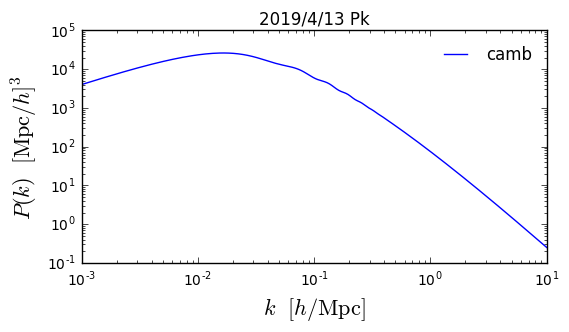

In [2]:
##########################
####### camb #############
##########################
import camb, os
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

# LCDM parameters
A_s = 2.1e-9
h=0.7
OmegaB = 0.046
OmegaM = 0.3
n_s = 0.97
tau = 0.054 ## only for primary CMB, not used for now, for simplicity

# beyond LCDM, not implemented yet
mnu = 0.0

### derived parameters
ombh2 = OmegaB*h**2
omch2 = (OmegaM-OmegaB)*h**2
H0=h*100

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=h*100, ombh2=ombh2, omch2=omch2, omk=0, 
                   tau=0, mnu=mnu, neutrino_hierarchy='normal')
pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
pars.set_matter_power(redshifts=[0.,], kmax=5.0)

#calculate results for these parameters
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='K')
for name in powers: print(name)
kcamb, zcamb, Pkcamb = results.get_matter_power_spectrum(minkh=1e-3, maxkh=10, npoints = 200)

figure(2, figsize=(6,3))
xscale('log');plt.yscale('log');plt.xlim(kcamb[0],kcamb[-1])
xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$',fontsize=16)
ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$',fontsize=16)
plot(kcamb,Pkcamb[0],'b-',label='camb')
title('2019/4/13 Pk')
legend(loc=0,frameon=0)

In [3]:
mnu, N = 0.0, 66
ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_0.0_66_parents.npy').T
idx = where( (PID0==-1) & (Mvir0>=10**11.5))[0]
ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_0.0_66_parents.npy')[idx,:].T
Cvir=Rvir/Rs

In [4]:
print len(PID),sum(PID==-1), sum(PID!=-1)

1563825 1563825 0


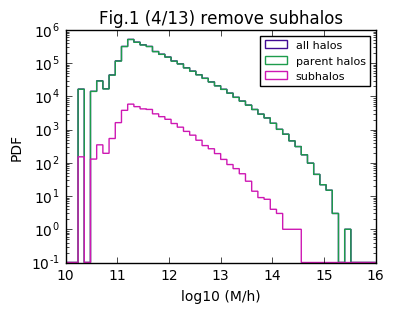

In [5]:
seed(68)
ibins=linspace(10, 16, 51)
f, ax=subplots(1,1,figsize=(4,3))
ax.hist(log10(Mvir0),bins=ibins,label='all halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0==-1]),bins=ibins,label='parent halos', 
        histtype='step',log=1,color=rand(3))
ax.hist(log10(Mvir0[PID0!=-1]),bins=ibins,label='subhalos', 
        histtype='step',log=1,color=rand(3))
ax.legend(fontsize=8,loc=0)
ax.set_xlabel('log10 (M/h)')
ax.set_ylabel('PDF')
ax.set_title('Fig.1 (4/13) remove subhalos')
show()

In [6]:
logM = log10(Mvir)
Mcut, Mcutlo = 14.0, 13 #12.5
logMbins0 = percentile(logM[ (logM>11.5) & (logM<Mcutlo)], linspace(0,100,101))
logMbins1 = percentile(logM[(logM>Mcutlo) & (logM<15.5)], linspace(0,100,101))
logMbins = concatenate( [logMbins0, logMbins1])
print unique(logMbins0).shape, unique(logMbins1).shape

(85,) (101,)


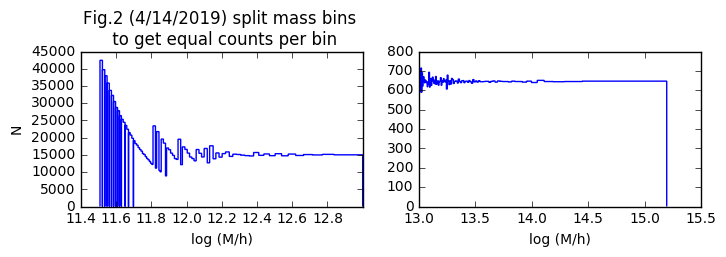

In [7]:
f, (ax1,ax2) = subplots(1,2, figsize=(8,2))
ax1.hist(logM, bins=logMbins0, histtype='step')
ax2.hist(logM, bins=logMbins1, histtype='step')
ax1.set_xlabel('log (M/h)')
ax2.set_xlabel('log (M/h)')
ax1.set_ylabel('N')
ax1.set_title('Fig.2 (4/14/2019) split mass bins \n to get equal counts per bin')
show()

In [8]:
## Cvir, Vmax, Spin
Cvir_mark = zeros(Mvir.shape)
Vmax_mark = zeros(Mvir.shape)
Spin_mark = zeros(Mvir.shape)

Nq=100
Cvir_quants = zeros(((len(logMbins)-1),Nq))
Vmax_quants = zeros(((len(logMbins)-1),Nq))
Spin_quants = zeros(((len(logMbins)-1),Nq))
for i in range(len(logMbins)-1):
    iidx=where( (logM>=logMbins[i]) & (logM<logMbins[i+1]))[0]
    Cvir_mark[iidx] = rankdata(Cvir[iidx])/len(iidx)
    Vmax_mark[iidx] = rankdata(Vmax[iidx])/len(iidx)
    Spin_mark[iidx] = rankdata(Spin[iidx])/len(iidx)
    if len(iidx)>0:
        Cvir_quants[i] = quantile(Cvir[iidx], linspace(0,1,Nq))
        Vmax_quants[i] = quantile(Vmax[iidx], linspace(0,1,Nq))
        Spin_quants[i] = quantile(Spin[iidx], linspace(0,1,Nq))

In [10]:
print logM.shape, Cvir.shape, Vmax.shape, Spin.shape
print Cvir_mark.shape, Vmax_mark.shape, Spin_mark.shape
print logMbins[1:].shape, Cvir_quants.shape

 (1563825,) (1563825,) (1563825,) (1563825,)
(1563825,) (1563825,) (1563825,)
(201,) (201, 100)


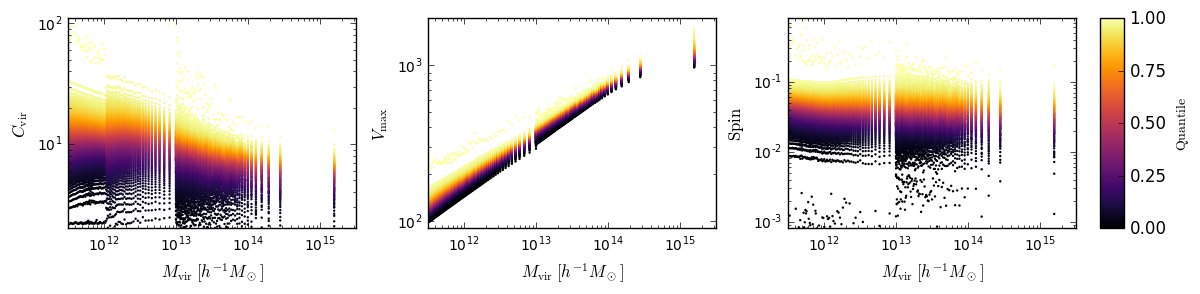

In [11]:
f, axes = subplots(1,3, figsize=(12,3))
imarks=linspace(0,1,Nq)
for i in range(3):
    iquant=[Cvir_quants, Vmax_quants, Spin_quants][i]
    for j in range(iquant.shape[0]):
        im=axes[i].scatter(10**logMbins[1:][j]*ones(len(iquant[j])), iquant[j], s=3, edgecolors='none', 
                      c=imarks, cmap='inferno',vmin=0, vmax=1)
    axes[i].set_xlim(10**11.5, 10**15.5)
    axes[i].set_xlabel(r'$M_{\rm vir}\; [h^{-1} M_\odot]$', fontsize=12)
    axes[i].set_ylabel([r'$C_{\rm vir}$', r'$V_{\rm max}$', r'${\rm Spin}$'][i], fontsize=12)
    axes[i].set_xscale('log');axes[i].set_yscale('log');
axes[0].set_ylim(2, 110)
axes[1].set_ylim(90, 2e3)
axes[2].set_ylim(8e-4, 0.8)
cax = f.add_axes([0.92, 0.2, 0.02, 0.7])
cbar = f.colorbar(im, cax=cax, label=r'${\rm Quantile}$')
cbar.ax.tick_params(labelsize=12) 
cbar.set_ticks(linspace(-0.25, 1., 6))
subplots_adjust(left=0.06, bottom=0.2, right=0.9, top=0.9, wspace=0.25, hspace=0)
# #savefig('plots/quantile.pdf');close()
show()

19167


/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: overflow encountered in power


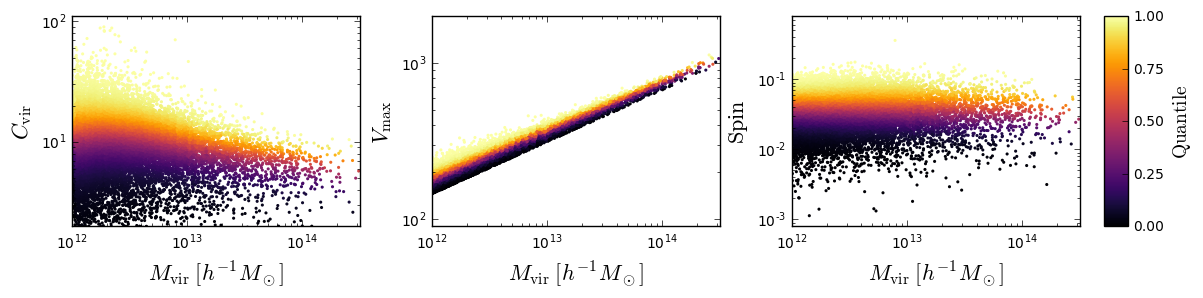

In [12]:
f, axes = subplots(1,3, figsize=(12,3))
iidx=where(logM>12)[0][choice(sum(logM>12), sum(logM>12)/30, replace=0)]
print len(iidx)
for i in range(3):
    ix=[Cvir, Vmax, Spin][i]
    imark=[Cvir_mark, Vmax_mark, Spin_mark][i]
    im=axes[i].scatter(10**logM[iidx], ix[iidx], s=5, edgecolors='none', 
                      c=imark[iidx], cmap='inferno',vmin=0, vmax=1)
    axes[i].set_xlim(10**12, 10**14.5)
    axes[i].set_ylim(amin(10**ix), amax(10**ix))
    axes[i].set_xlabel(r'$M_{\rm vir}\; [h^{-1} M_\odot]$', fontsize=16)
    axes[i].set_ylabel([r'$C_{\rm vir}$', r'$V_{\rm max}$', r'${\rm Spin}$'][i], fontsize=16)
    axes[i].set_xscale('log');axes[i].set_yscale('log');
axes[0].set_ylim(2, 110)
axes[1].set_ylim(90, 2e3)
axes[2].set_ylim(8e-4, 0.8)
cax = f.add_axes([0.92, 0.2, 0.02, 0.7])
cbar = f.colorbar(im, cax=cax)
#cbar.ax.tick_params(labelsize=12) 
cbar.set_label(label=r'${\rm Quantile}$',size=14)#,weight='bold')
cbar.set_ticks(linspace(-0.25, 1., 6))
subplots_adjust(left=0.06, bottom=0.2, right=0.9, top=0.9, wspace=0.25, hspace=0)
#savefig('plots/quantile.pdf');close()

In [177]:
Lbox = 512.0 #Mpc/h
Ngrid = 256.0
gridbins=arange(Ngrid)
Lgrid = Lbox/Ngrid
dataset_name='Subsample'
Nbin=10
Mmin=11.5

def gridding (pos):
    grid = histogramdd(pos/Lbox*Ngrid,bins=[gridbins,gridbins,gridbins])[0]
    grid = grid/mean(grid) - 1.0
    return grid

def PS (pos1, pos2, dogrid=1):
    if dogrid:
        grid1 = gridding(pos1)
        grid2 = gridding(pos2)
    else:
        grid1, grid2 = pos1, pos2
    k, ps3d = WLanalysis.CrossPowerSpectrum3D(grid1, grid2, bins=Nbin)
    return 2*pi*k/Lbox, ps3d*(Lgrid/Ngrid)**3

def Phm_gen (mnu, N, Mcut=14.0, Mcutlo=12.5, Mmin=11.5, Nbin=Nbin): ## position of halo and particle, in unit of Mpc/h
    ########### particles
    subsample_fn = 'snap/snapshot_mnv_%.1f/snapshot_%03d_idmod_101_0.hdf5'%(mnu,N)
    f=h5py.File(subsample_fn,'r')
    dataset = f[dataset_name]
    particle_pos = dataset['Position']/1e3
    gridP = gridding(particle_pos)
    k, Pmm = PS(gridP, gridP, dogrid=0)    

    ########### halos
    ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_%.1f_%02d_parents.npy'%(mnu,N)).T
    idx = where((PID0==-1)&(log10(Mvir0)>Mmin))[0]
    ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_%.1f_%02d_parents.npy'%(mnu,N))[idx,:].T
    Cvir=Rvir/Rs
    logM = log10(Mvir)
    halo_pos = array([x,y,z]).T
    k, Phm12 = PS(gridP, gridding(halo_pos[logM<Mcutlo]), dogrid=0)
    k, Phm14 = PS(gridP, gridding(halo_pos[logM>Mcut]), dogrid=0)
    
    ## shot noise
    Npart = len(particle_pos)
    Nmm = Lbox**3/Npart
    Nhm12 = Lbox**3/sqrt(Npart)/sqrt(sum(logM<Mcutlo))
    Nhm14 = Lbox**3/sqrt(Npart)/sqrt(sum(logM>Mcut))
    
    ####### for each AB property: 2 halo masses, hi/lo half-> 4 combinations
    
    logMbins0 = percentile(logM[(logM>Mmin) & (logM<Mcutlo)], linspace(0,100,101))
    logMbins1 = percentile(logM[(logM>Mcut) & (logM<15.5)], linspace(0,100,51))
    logMbins = unique(concatenate( [logMbins0, logMbins1]))
    
    out_AB_M12=zeros((3,2,Nbin))
    out_AB_M14=zeros((3,2,Nbin))
    Nhm_M12 = zeros((3,2))
    Nhm_M14 = zeros((3,2))
    
    i=0
    for ix in (Cvir, Vmax, Spin):
        print ['Cvir','Vmax', 'Spin'][i]
        ix_mark = zeros(logM.shape)
        for j in range(len(logMbins)-1): ####### put in mark for each mass bin
            iidx=where( (logM>logMbins[j]) & (logM<logMbins[j+1]))[0]
            ix_mark[iidx] = rankdata(ix[iidx])/len(iidx)
        k, iPhm14hi = PS(gridP, gridding(halo_pos[(logM>Mcut) & (ix_mark>0.5) ]), dogrid=0)
        k, iPhm14lo = PS(gridP, gridding(halo_pos[(logM>Mcut) & (ix_mark<0.5) ]), dogrid=0)
        k, iPhm12hi = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark>0.5)]), dogrid=0)
        k, iPhm12lo = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark<0.5)]), dogrid=0)   
        out_AB_M12[i]=[iPhm12hi,iPhm12lo]
        out_AB_M14[i]=[iPhm14hi,iPhm14lo] 
        i+=1
    return k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14

In [14]:
# out = Phm_gen(0.0, 66)
# save('Phm/Pks_mnu%.1f_%i.npy'%(mnu,N),out)

In [15]:
############## long operation
# mnu, N = 0.0, 66
# for N in (66, 56, 47, 42, 37):
#     for mnu in (0.0, 0.1, 0.6):
#         print mnu, N
#         #out = Phm_gen(mnu, N)
#         save('Phm/Pks_mnu%.1f_%i.npy'%(mnu,N),out)
#         out=load('Phm/Pks_mnu%.1f_%i.npy'%(mnu,N))
#         k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14 = out

#         seed(808)
#         f, (ax,ax4,ax2) = subplots(1,3,figsize=(10,4))
#         icolor=rand(20,3)
#         ax.plot(k,Pmm,'-', lw=2,color=icolor[0],label='Pmm')
#         ax.plot(k,Phm12,'-', lw=2,color=icolor[1],label='Phm12')
#         ax.plot(k,Phm14,'-', lw=2,color=icolor[2],label='Phm14')
#         ax.plot(k,ones(len(k))*Nmm,'--',color=icolor[0])
#         ax.plot(k,ones(len(k))*Nhm12,'--',color=icolor[1])
#         ax.plot(k,ones(len(k))*Nhm14,'--',color=icolor[2])
#         ax.plot(kcamb,Pkcamb[0],'k-',label='camb')
#         ax.set_ylabel('Pk')

#         for j in range(3):
#             ilabel=['Cvir','Vmax', 'Spin'][j]
#             ax4.plot(k,out_AB_M14[j, 0]/out_AB_M14[j, 1]-1,'-',lw=2,color=icolor[3+j],label='%s'%(ilabel))

#         for j in range(3):
#             ilabel=['Cvir','Vmax', 'Spin'][j]
#             ax2.plot(k,out_AB_M12[j, 0]/out_AB_M12[j, 1]-1,'-',lw=2,color=icolor[3+j],label='%s'%(ilabel))

#         ax.set_xscale('log');ax.set_yscale('log')
#         ax2.set_xscale('log');ax4.set_xscale('log');

#         ax.set_xlim(k[3],k[-1])
#         ax2.set_xlim(k[3],k[-1])
#         ax2.plot(k,zeros(len(k)),'k-')
#         ax4.set_xlim(k[3],k[-1])
#         ax4.plot(k,zeros(len(k)),'k-')
#         ax4.set_xlabel('k')
#         ax4.set_ylabel('b_hi/b_lo-1')
#         ax2.set_ylabel('b_hi/b_lo-1')

#         ax.legend(frameon=0, fontsize=8, loc=0,ncol=2)
#         ax2.legend(frameon=0, fontsize=8, loc=0, title='M=[11.5, 12.5]')
#         ax4.legend(frameon=0, fontsize=8, loc=0, title='M=[14,15.5]')
# #         ax4.set_ylim(-0.2, 0.4)
#         ax.set_title('Fig.4 (4/13/2019) assembly bias \n Mnu=%s, snap=%i'%(mnu, N), fontsize=10)
#         plt.tight_layout()
#         #show()
#         savefig('plots/Pks_mnu%.1f_%i.jpg'%(mnu,N))
#         close()

In [16]:
a_arr = array([1.0, 0.678818, 0.488158, 0.403786, 0.330213])
N_arr = array([66, 56, 47, 42, 37])
z_arr = 1.0/a_arr-1
print z_arr

[0.         0.47314891 1.04851708 1.47655937 2.02834837]


In [17]:
#k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14
out0_arr = [load('Phm/Pks_mnu%.1f_%i.npy'%(0.0,N)) for N in N_arr[:3]]
out1_arr = [load('Phm/Pks_mnu%.1f_%i.npy'%(0.1,N)) for N in N_arr[:3]]
out6_arr = [load('Phm/Pks_mnu%.1f_%i.npy'%(0.6,N)) for N in N_arr[:3]]

In [18]:
colors=['orangered','mediumorchid',
        'seagreen','goldenrod','darkred',
        'plum','forestgreen','darkmagenta','deepskyblue','darkcyan','steelblue']

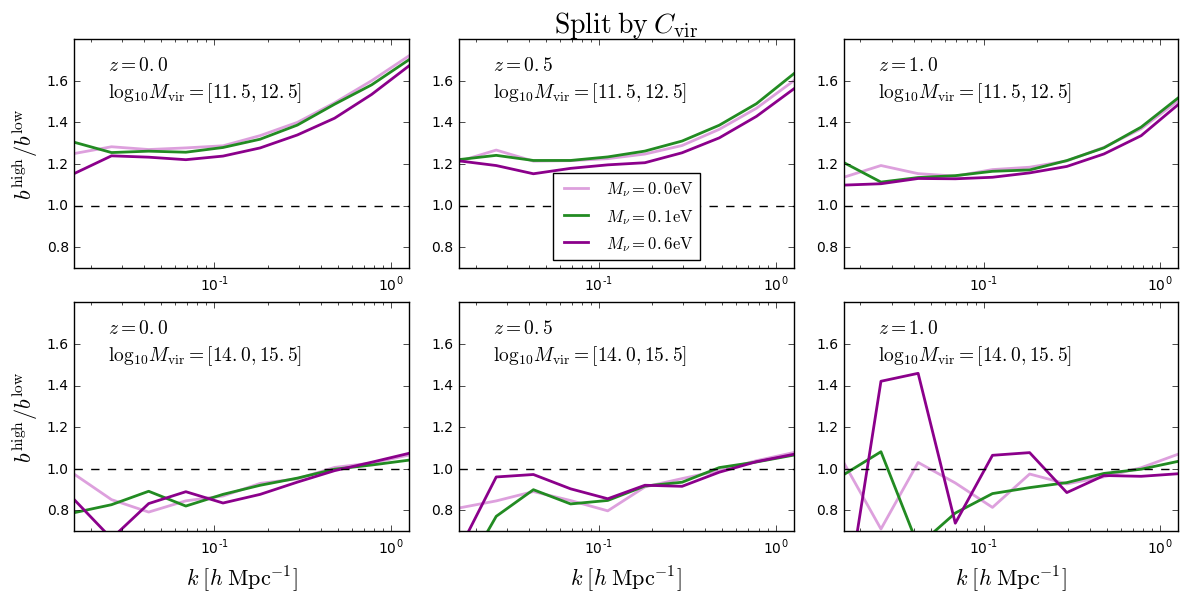

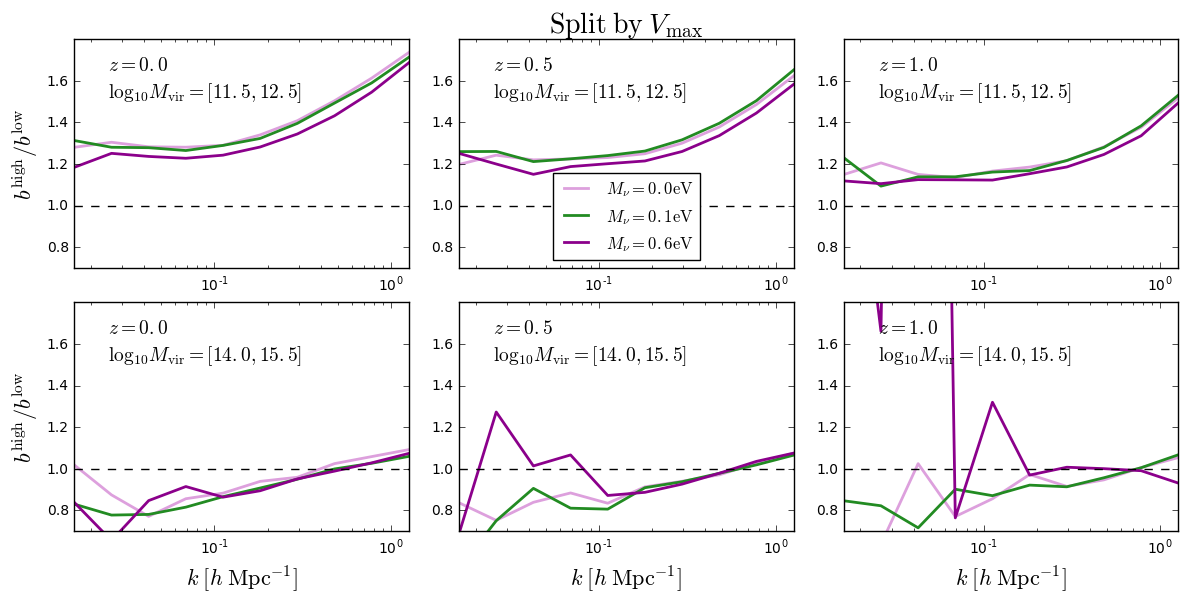

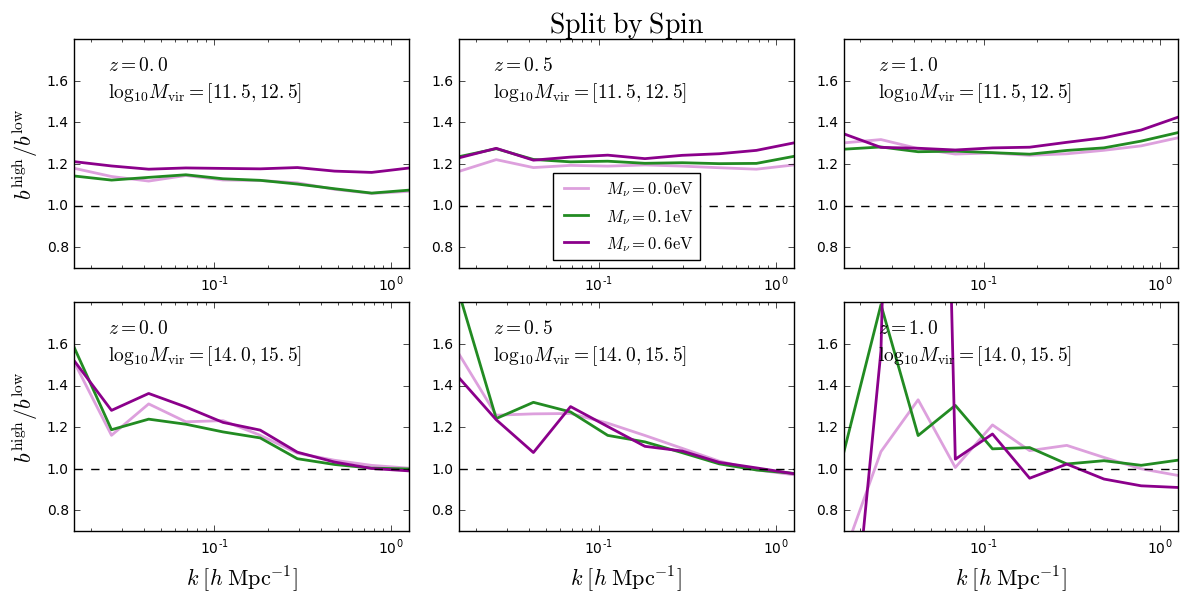

In [19]:
for j in range(3): ## cvir, vmax, spin counter(1,):#(1,):#
    jlabel=[r'${\rm Split\; by\;} C_{\rm vir}$', 
            r'${\rm Split\; by\;} V_{\rm max}$', 
            r'${\rm Split\; by\; Spin}$'][j]
    f, [axes, axes2] = subplots(2,3, figsize=(12,6))
    for i in range(3): ## redshift counter
        for nmnu in range(3): ## neutrino mass counter
            k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], AB_M12, AB_M14 = [out0_arr,out1_arr,out6_arr][nmnu][i]
    
            ilabel=[r'$M_\nu= %.1f {\rm eV}$'%(mnu) for mnu in (0, 0.1, 0.6)][nmnu]
            axes[i].plot(k, AB_M12[j,0]/AB_M12[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
            axes2[i].plot(k, AB_M14[j,0]/AB_M14[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
        axes[i].set_xscale('log'); axes2[i].set_xscale('log')
        axes[i].set_xlim(k[0],k[-1]);axes2[i].set_xlim(k[0],k[-1])
        axes[i].set_ylim(0.7, 1.8);axes2[i].set_ylim(0.7, 1.8)
        axes[i].text(0.025, 1.65, r'$z=%.1f$'%(z_arr[i]), fontsize=14)
        axes[i].text(0.025, 1.52, r'$\log_{10}M_{\rm vir}=[11.5, 12.5]$', fontsize=14)
        axes2[i].text(0.025, 1.65, r'$z=%.1f$'%(z_arr[i]), fontsize=14)
        axes2[i].text(0.025, 1.52, r'$\log_{10}M_{\rm vir}=[14.0, 15.5]$', fontsize=14)

        axes[i].plot([k[0], k[-1]], ones(2),'k--',lw=1)
        axes2[i].plot([k[0], k[-1]], ones(2),'k--',lw=1)
        axes2[i].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=16)
    axes[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
    axes2[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
    axes[1].legend(loc='lower center', frameon=1, fontsize=12, columnspacing=0.5)#, title=jlabel)
    axes[1].set_title(jlabel, fontsize=20)
    subplots_adjust(left=0.06, bottom=0.1, right=0.98, top=0.92, wspace=0.15, hspace=0.15)
    #savefig('plots/assemblybias_%s.pdf'%(['cvir','vmax','spin'][j]));close()

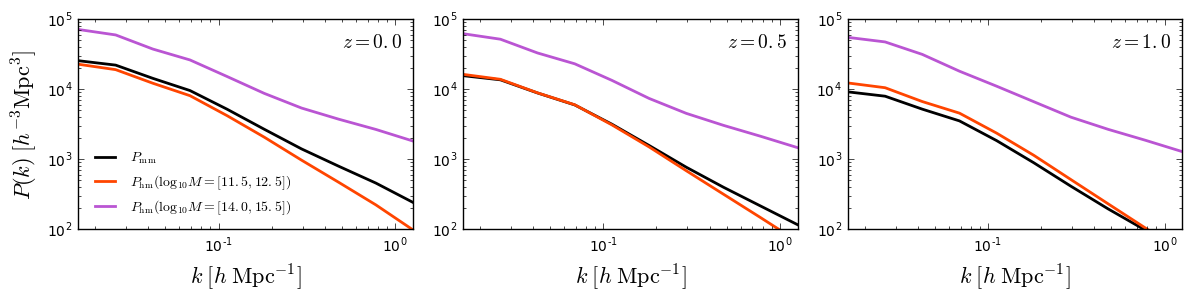

In [20]:
f, axes = subplots(1,3, figsize=(12,3))
for i in range(3):
    k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14 = out0_arr[i]
    axes[i].plot(k, Pmm, color='k', lw=2, label=r'$P_{\rm mm}$')
    axes[i].plot(k, Phm12, color=colors[0], lw=2, label=r'$P_{\rm hm} (\log_{10}M=[11.5,12.5])$')
    axes[i].plot(k, Phm14, color=colors[1], lw=2, label=r'$P_{\rm hm} (\log_{10}M=[14.0,15.5])$')
    axes[i].set_xscale('log'), axes[i].set_yscale('log')
    axes[i].set_xlim(k[0],k[-1]);axes[i].set_ylim(1e2, 1e5)
    axes[i].text(0.5, 4e4, r'$z=%.1f$'%(z_arr[i]), fontsize=14)
    axes[i].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=16)
axes[0].set_ylabel(r'$P(k)\; [h^{-3} {\rm Mpc}^{3}]$', fontsize=16)
axes[0].legend(loc='lower left', frameon=0, fontsize=10)
subplots_adjust(left=0.06, bottom=0.2, right=0.98, top=0.9, wspace=0.15, hspace=0)
#savefig('plots/Pk.pdf');close()

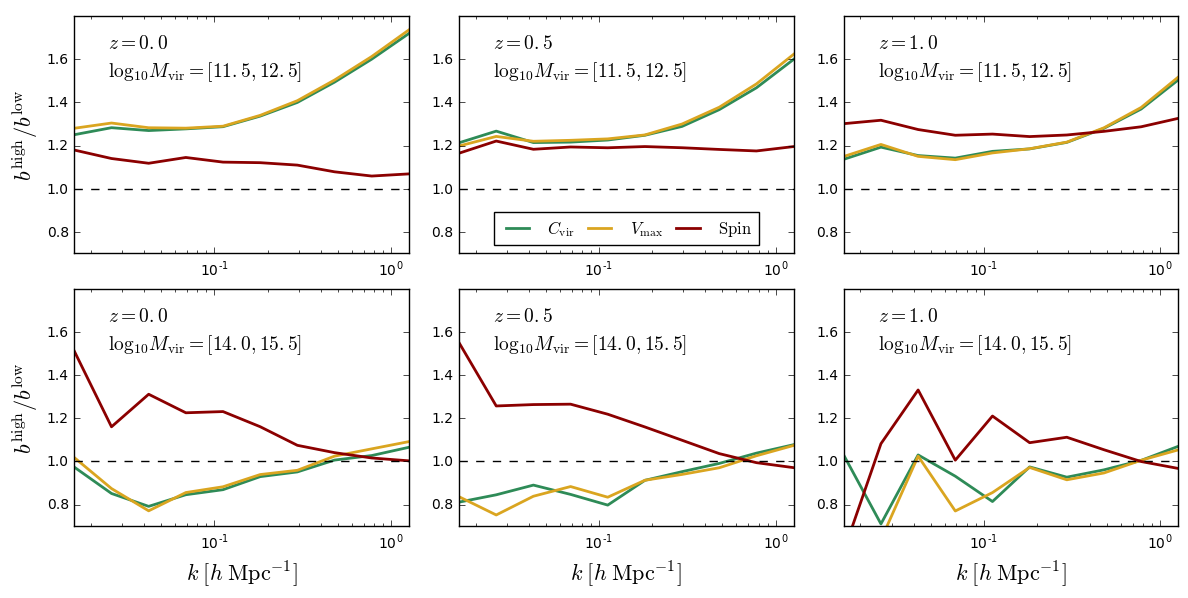

In [21]:
f, [axes, axes2] = subplots(2,3, figsize=(12,6))
for i in range(3):## redshift counter
    k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], AB0_M12, AB0_M14 = out0_arr[i]
    for j in range(3):
        ilabel=[r'$C_{\rm vir}$', r'$V_{\rm max}$', r'${\rm Spin}$'][j]
        axes[i].plot(k, AB0_M12[j,0]/AB0_M12[j,1], color=colors[j+2], lw=2, label=ilabel)
        axes2[i].plot(k, AB0_M14[j,0]/AB0_M14[j,1], color=colors[j+2], lw=2, label=ilabel)
    axes[i].set_xscale('log'); axes2[i].set_xscale('log')
    axes[i].set_xlim(k[0],k[-1]);axes2[i].set_xlim(k[0],k[-1])
    axes[i].set_ylim(0.7, 1.8);axes2[i].set_ylim(0.7, 1.8)
    axes[i].text(0.025, 1.65, r'$z=%.1f$'%(z_arr[i]), fontsize=14)
    axes[i].text(0.025, 1.52, r'$\log_{10}M_{\rm vir}=[11.5, 12.5]$', fontsize=14)
    axes2[i].text(0.025, 1.65, r'$z=%.1f$'%(z_arr[i]), fontsize=14)
    axes2[i].text(0.025, 1.52, r'$\log_{10}M_{\rm vir}=[14.0, 15.5]$', fontsize=14)
    
    axes[i].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[i].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[i].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=16)
axes[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes2[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes[1].legend(loc='lower center', frameon=1, fontsize=12, columnspacing=0.5, ncol=3)
subplots_adjust(left=0.06, bottom=0.1, right=0.98, top=0.95, wspace=0.15, hspace=0.15)
#savefig('plots/assemblybias_all3.pdf');close()

In [110]:
################ match halos accross neutrino mass
PID0= load('cat/mnv_0.0_66_parents.npy').T[-1]
PID0b= load('cat/mnv_0.0_56_parents.npy').T[-1]
PID0c= load('cat/mnv_0.0_47_parents.npy').T[-1]
PID1= load('cat/mnv_0.1_66_parents.npy').T[-1]
PID6= load('cat/mnv_0.6_66_parents.npy').T[-1]

ID0, Mvir0, Vmax0, Rvir0, Rs0, x0, y0, z0, Spin0, PID0 = load('cat/mnv_0.0_66_parents.npy')[PID0==-1].T
ID0b, Mvir0b, Vmax0b, Rvir0b, Rs0b, x0b, y0b, z0b, Spin0b, PID0b = load('cat/mnv_0.0_56_parents.npy')[PID0b==-1].T
ID0c, Mvir0c, Vmax0c, Rvir0c, Rs0c, x0c, y0c, z0c, Spin0c, PID0c = load('cat/mnv_0.0_47_parents.npy')[PID0c==-1].T
ID1, Mvir1, Vmax1, Rvir1, Rs1, x1, y1, z1, Spin1, PID1 = load('cat/mnv_0.1_66_parents.npy')[PID1==-1].T
ID6, Mvir6, Vmax6, Rvir6, Rs6, x6, y6, z6, Spin6, PID6 = load('cat/mnv_0.6_66_parents.npy')[PID6==-1].T

Cvir0=Rvir0/Rs0
Cvir6=Rvir6/Rs6
Cvir1=Rvir1/Rs1

Cvir0b=Rvir0b/Rs0b
Cvir0c=Rvir0c/Rs0c
idxcut=where(Mvir0>10**11.5)[0]
print idxcut.shape

(1563825,)


In [111]:
# pos0=array([x0,y0,z0]).T[idxcut]
# pos0m=array([x0,y0,z0,log10(Mvir0)]).T[idxcut]

# tree0b=spatial.KDTree(array([x0b,y0b,z0b]).T)
# tree0c=spatial.KDTree(array([x0c,y0c,z0c]).T)
# print 'done tree 3D'
# d0b, idx_0b=tree0b.query(pos0)
# d0c, idx_0c=tree0c.query(pos0)
# print 'done match 3D'

# tree0bmass=spatial.KDTree(array([x0b,y0b,z0b, log10(Mvir0b)]).T)
# tree0cmass=spatial.KDTree(array([x0c,y0c,z0c, log10(Mvir0c)]).T)
# print 'done tree 4D'
# dm0b, idx_m0b=tree0bmass.query(pos0m)
# dm0c, idx_m0c=tree0cmass.query(pos0m)
# print 'done match 4D'

# save('sep3D_idx_mnu0.0_z0_z0.5.npy',[d0b, idx_0b  ])
# save('sep3D_idx_mnu0.0_z0_z1.npy'  ,[d0c, idx_0c  ])
# save('sep4D_idx_mnu0.0_z0_z0.5.npy',[dm0b, idx_m0b])
# save('sep4D_idx_mnu0.0_z0_z1.npy'  ,[dm0c, idx_m0c])

done tree 3D
done match 3D
done tree 4D
done match 4D


In [112]:
d0b, idx_0b    =   load('sep3D_idx_mnu0.0_z0_z0.5.npy'  )
d0c, idx_0c    =   load('sep3D_idx_mnu0.0_z0_z1.npy'    )
dm0b, idx_m0b  =   load('sep4D_idx_mnu0.0_z0_z0.5.npy'  )
dm0c, idx_m0c  =   load('sep4D_idx_mnu0.0_z0_z1.npy'    )

In [113]:
# tree0=spatial.KDTree(array([x0,y0,z0]).T)
# tree6=spatial.KDTree(array([x6,y6,z6]).T)
# tree1=spatial.KDTree(array([x1,y1,z1]).T)
# print 'done trees 3d'
# tree0mass=spatial.KDTree(array([x0,y0,z0, log10(Mvir0)]).T)
# tree1mass=spatial.KDTree(array([x1,y1,z1, log10(Mvir1)]).T)
# tree6mass=spatial.KDTree(array([x6,y6,z6, log10(Mvir6)]).T)
# print 'done trees 4d'

# pos0=array([x0,y0,z0]).T[idxcut]
# d06,idx_06=tree6.query(pos0)
# d01,idx_01=tree1.query(pos0)

# print 'done match 3d'

# pos0m=array([x0,y0,z0,log10(Mvir0)]).T[idxcut]
# dm06, idx_m06=tree6mass.query(pos0m)
# dm01, idx_m01=tree1mass.query(pos0m)

# print 'done match 4d'

# save('sep3D_idx_mnu0.0_mnu0.6.npy',[d06,idx_06])
# save('sep3D_idx_mnu0.0_mnu0.1.npy',[d01,idx_01])
# save('sep4D_idx_mnu0.0_mnu0.6.npy',[dm06,idx_m06])
# save('sep4D_idx_mnu0.0_mnu0.1.npy',[dm01,idx_m01])

done trees 3d
done trees 4d
done match 3d
done match 4d


In [116]:
d06,idx_06 = load('sep3D_idx_mnu0.0_mnu0.6.npy')
d01,idx_01 = load('sep3D_idx_mnu0.0_mnu0.1.npy')
dm06,idx_m06 = load('sep4D_idx_mnu0.0_mnu0.6.npy')
dm01,idx_m01 = load('sep4D_idx_mnu0.0_mnu0.1.npy')

idx_0b, idx_0c, idx_m0b, idx_m0c, idx_01, idx_06, idx_m01, idx_m06 = [iidx.astype(int) for iidx in
            [idx_0b, idx_0c, idx_m0b, idx_m0c, idx_01, idx_06, idx_m01, idx_m06]]

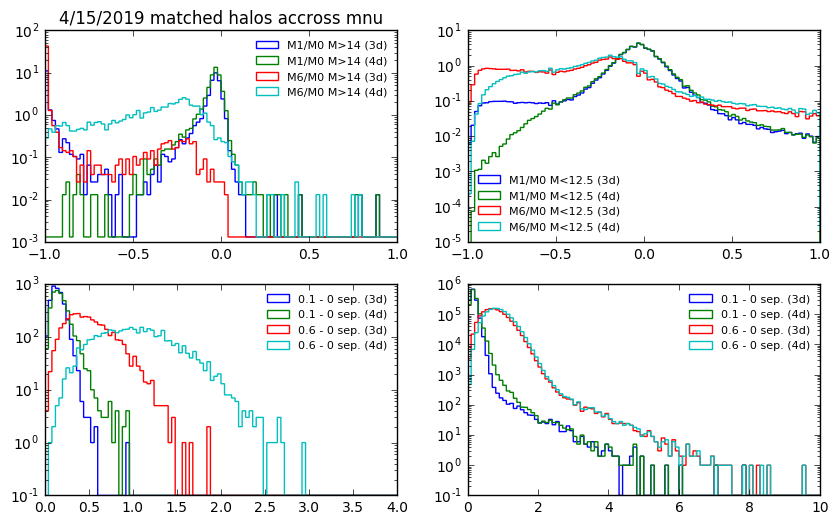

In [127]:
Mvir0cut=Mvir0[idxcut]

f, ((ax1, ax3), (ax2, ax4)) = subplots(2,2, figsize=(10,6))

ax1.hist( (Mvir1[idx_01]/Mvir0cut)[Mvir0cut>1e14]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M1/M0 M>14 (3d)')
ax1.hist( (Mvir1[idx_m01]/Mvir0cut)[Mvir0cut>1e14]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M1/M0 M>14 (4d)')

ax1.hist( (Mvir6[idx_06]/Mvir0cut)[Mvir0cut>1e14]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M6/M0 M>14 (3d)')
ax1.hist( (Mvir6[idx_m06]/Mvir0cut)[Mvir0cut>1e14]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M6/M0 M>14 (4d)')

ax2.hist(d01[Mvir0cut>1e14], histtype='step',log=1,label='0.1 - 0 sep. (3d)',bins=linspace(0,4,101))
ax2.hist(dm01[Mvir0cut>1e14], histtype='step',log=1,label='0.1 - 0 sep. (4d)',bins=linspace(0,4,101))
ax2.hist(d06[Mvir0cut>1e14], histtype='step',log=1,label='0.6 - 0 sep. (3d)',bins=linspace(0,4,101))
ax2.hist(dm06[Mvir0cut>1e14], histtype='step',log=1,label='0.6 - 0 sep. (4d)',bins=linspace(0,4,101))

ax3.hist( (Mvir1[idx_01]/Mvir0cut)[Mvir0cut<10**12.5]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M1/M0 M<12.5 (3d)')
ax3.hist( (Mvir1[idx_m01]/Mvir0cut)[Mvir0cut<10**12.5]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M1/M0 M<12.5 (4d)')

ax3.hist( (Mvir6[idx_06]/Mvir0cut)[Mvir0cut<10**12.5]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M6/M0 M<12.5 (3d)')
ax3.hist( (Mvir6[idx_m06]/Mvir0cut)[Mvir0cut<10**12.5]-1, histtype='step',log=1,
        bins=linspace(-1,1,101),normed=1, label='M6/M0 M<12.5 (4d)')

ax4.hist(d01[Mvir0cut<10**12.5], histtype='step',log=1,label='0.1 - 0 sep. (3d)',bins=linspace(0,10,101))
ax4.hist(dm01[Mvir0cut<10**12.5], histtype='step',log=1,label='0.1 - 0 sep. (4d)',bins=linspace(0,10,101))
ax4.hist(d06[Mvir0cut<10**12.5], histtype='step',log=1,label='0.6 - 0 sep. (3d)',bins=linspace(0,10,101))
ax4.hist(dm06[Mvir0cut<10**12.5], histtype='step',log=1,label='0.6 - 0 sep. (4d)',bins=linspace(0,10,101))

ax1.legend(loc=0, fontsize=8, frameon=0)
ax2.legend(loc=0, fontsize=8, frameon=0)
ax3.legend(loc=0, fontsize=8, frameon=0)
ax4.legend(loc=0, fontsize=8, frameon=0)

ax1.set_title('4/15/2019 matched halos accross mnu')
show()

42448
0.100
tree built (2686292,)
done tree query (42448,) (42200,)
0.316
tree built (2686292,)
done tree query (42448,) (42197,)
1.000
tree built (2686292,)
done tree query (42448,) (42197,)
3.162
tree built (2686292,)
done tree query (42448,) (42113,)
10.000
tree built (2686292,)
done tree query (42448,) (41774,)


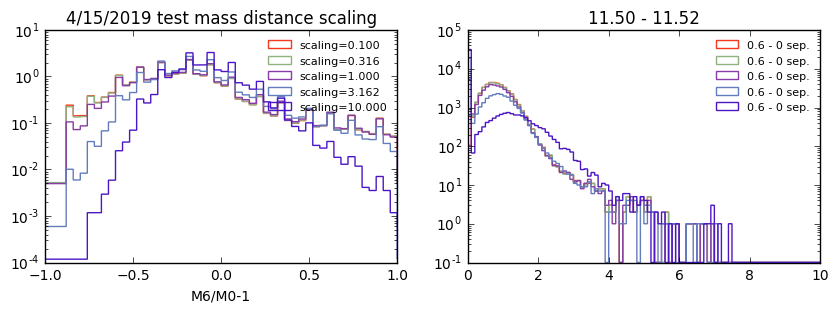

In [132]:
############# long-ish computing
ilo, ihi=10**11.5, 10**11.52#11.5, 12
iidxcut = where( (Mvir0>ilo) & (Mvir0<ihi))[0]
print len(iidxcut)

seed(808)
f, (ax1, ax2) = subplots(1,2, figsize=(10,3))
for ir in logspace(log10(0.1), 1,5):
    icolor=rand(3)
    print '%.3f'%(ir)
    iidx6=where((Mvir6>0.1*ilo) & (Mvir6<2.5*ihi))[0]
    itree=spatial.KDTree(array([x6,y6,z6, ir*log10(Mvir6)]).T[iidx6])
    print 'tree built', iidx6.shape
    ipos=array([x0,y0,z0,ir*log10(Mvir0)]).T[iidxcut]
    ix, iidx=itree.query(ipos)
    ix_3d = sqrt(ix**2-(ir*log10(Mvir6[iidx])-ir*log10(Mvir0[iidxcut]))**2)
    print 'done tree query', ix.shape, unique(iidx).shape

    ax1.hist((Mvir6[iidx6][iidx]/Mvir0[iidxcut])-1,color=icolor, histtype='step',log=1,
            bins=linspace(-1,1,51),normed=1, label='scaling=%.3f'%(ir))
    
    ax2.hist(ix_3d, histtype='step',log=1,color=icolor,label='0.6 - 0 sep.',bins=linspace(0,10,101))

ax1.legend(loc=0, fontsize=8, frameon=0)
ax2.legend(loc=0, fontsize=8, frameon=0)
ax1.set_title('4/15/2019 test mass distance scaling')
ax2.set_title('%.2f - %.2f'%(log10(ilo), log10(ihi)))
ax1.set_xlabel('M6/M0-1')

show()

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


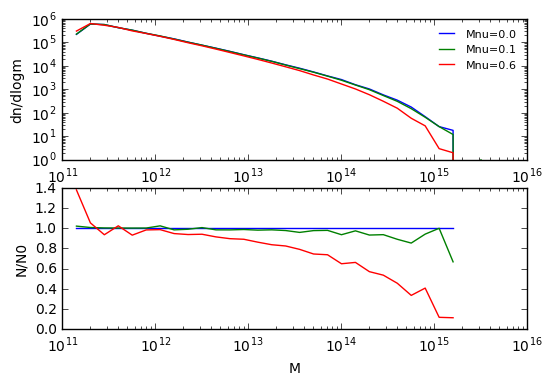

In [120]:
ibins=logspace(11, 15.5, 31)
hist_arr = [histogram(imvir, bins=ibins)[0] 
            for imvir in [Mvir0, Mvir1, Mvir6]]

f, (ax1,ax2) = subplots(2,1,figsize=(6,4))
for i in range(3):
    ax1.plot(ibins[1:], hist_arr[i], label='Mnu=%.1f'%([0,0.1,0.6][i]))
    ax2.plot(ibins[1:], hist_arr[i].astype(float)/hist_arr[0])
    
ax1.legend(fontsize=8, frameon=0)
ax1.set_xscale('log');ax2.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xlabel('M')
ax1.set_ylabel('dn/dlogm')
ax2.set_ylabel('N/N0')
show()

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered 

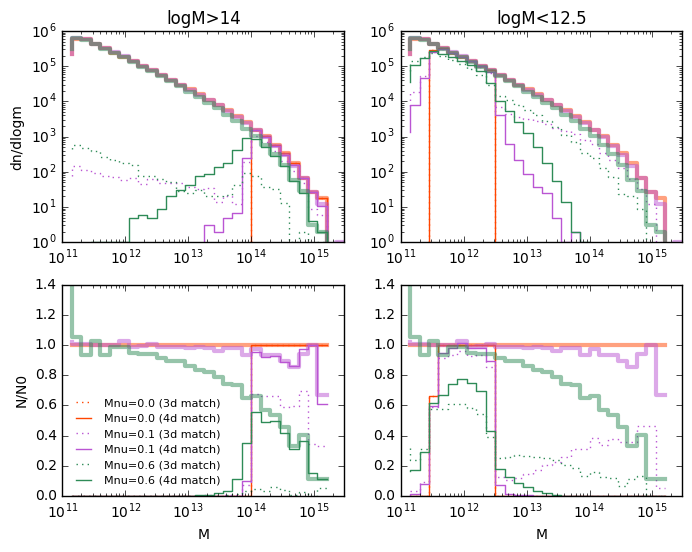

In [121]:
# idxcut=where(Mvir0>10**11.5)[0]
# pos0=array([x0,y0,z0]).T[idxcut]
# d06,idx_06=tree6.query(pos0)
# d01,idx_01=tree1.query(pos0)

idxcut14=where(Mvir0[idxcut]>10**14)[0]
idxcut12=where(Mvir0[idxcut]<10**12.5)[0]

########## plot out the HMF for matched halos
ibins2=logspace(11, 15.5, 31)
hist_arr2 = [histogram(imvir[idxcut14], bins=ibins2)[0] for imvir in 
            [Mvir0[idxcut], Mvir1[idx_01], Mvir6[idx_06]]]

hist_arr3 = [histogram(imvir[idxcut14], bins=ibins2)[0] for imvir in 
            [Mvir0[idxcut], Mvir1[idx_m01], Mvir6[idx_m06]]]

hist_arr2b = [histogram(imvir[idxcut12], bins=ibins2)[0] for imvir in 
            [Mvir0[idxcut], Mvir1[idx_01], Mvir6[idx_06]]]

hist_arr3b = [histogram(imvir[idxcut12], bins=ibins2)[0] for imvir in 
            [Mvir0[idxcut], Mvir1[idx_m01], Mvir6[idx_m06]]]


f, ((ax1,ax2),(ax3, ax4)) = subplots(2,2,figsize=(8,6))
for i in range(3):
    ## original HMF
    ax1.plot(ibins[1:], hist_arr[i], color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    ax3.plot(ibins[1:], hist_arr[i].astype(float)/hist_arr[0], 
             color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    
    ## 3d position matched HMF
    ax1.plot(ibins2[1:], hist_arr2[i],':',color=colors[i],
             label='Mnu=%.1f (3d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    ax3.plot(ibins2[1:], hist_arr2[i].astype(float)/hist_arr[0],':',
             color=colors[i],drawstyle='steps',
             label='Mnu=%.1f (3d match)'%([0,0.1,0.6][i]))
    
    ## 4d pos+mass matched HMF
    ax1.plot(ibins2[1:], hist_arr3[i],'-',color=colors[i],
            label='Mnu=%.1f (4d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    ax3.plot(ibins2[1:], hist_arr3[i].astype(float)/hist_arr[0],'-',color=colors[i],
            label='Mnu=%.1f (4d match)'%([0,0.1,0.6][i]),drawstyle='steps')

    ########## M12
    ax2.plot(ibins[1:], hist_arr[i], color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    ax4.plot(ibins[1:], hist_arr[i].astype(float)/hist_arr[0], 
             color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    
    ## 3d position matched HMF
    ax2.plot(ibins2[1:], hist_arr2b[i],':',color=colors[i],
             label='Mnu=%.1f (3d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    ax4.plot(ibins2[1:], hist_arr2b[i].astype(float)/hist_arr[0],':',
             color=colors[i],drawstyle='steps',
             label='Mnu=%.1f (3d match)'%([0,0.1,0.6][i]))
    
    ## 4d pos+mass matched HMF
    ax2.plot(ibins2[1:], hist_arr3b[i],'-',color=colors[i],
            label='Mnu=%.1f (4d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    ax4.plot(ibins2[1:], hist_arr3b[i].astype(float)/hist_arr[0],'-',color=colors[i],
            label='Mnu=%.1f (4d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    
ax3.legend(fontsize=8, frameon=0,ncol=1,columnspacing=0.5,loc='lower left')
ax1.set_xlim(1e11, 3e15);ax2.set_xlim(1e11, 3e15)
ax3.set_xlim(1e11, 3e15);ax4.set_xlim(1e11, 3e15)
ax1.set_title('logM>14')
ax2.set_title('logM<12.5')
ax1.set_xscale('log');ax2.set_xscale('log')
ax3.set_xscale('log');ax4.set_xscale('log')
ax1.set_yscale('log');ax2.set_yscale('log')
ax3.set_xlabel('M');ax4.set_xlabel('M')
ax1.set_ylabel('dn/dlogm')
ax3.set_ylabel('N/N0')
show()


(3258362,) (3479181,) (3220124,) (3220124,) (3220124,)


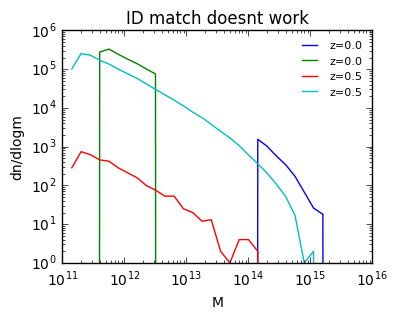

In [122]:
######### next try match ID #######
#ID0, Mvir0, Vmax0, Rvir0, Rs0, x0, y0, z0, Spin0, PID0 = load('cat/mnv_0.0_66_parents.npy').T
#ID0b, Mvir0b, Vmax0b, Rvir0b, Rs0b, x0b, y0b, z0b, Spin0b, PID0b = load('cat/mnv_0.0_56_parents.npy').T

IDcomb, idx0, idx0b = intersect1d(ID0, ID0b, return_indices=1)
Mvir0_sort = Mvir0[idx0]
Mvir0b_sort = Mvir0b[idx0b]

print ID0.shape, ID0b.shape, IDcomb.shape, Mvir0_sort.shape, Mvir0b_sort.shape

ibins=logspace(11, 15.5, 31)
idxcut14_sort=where(Mvir0_sort>10**14)[0]
idxcut12_sort=where((Mvir0_sort<10**12.5) & (Mvir0_sort>10**11.5))[0]

hist14 = [histogram(imvir[idxcut14_sort], bins=ibins)[0] 
            for imvir in [Mvir0_sort, Mvir0b_sort]]
hist12 = [histogram(imvir[idxcut12_sort], bins=ibins)[0] 
            for imvir in [Mvir0_sort, Mvir0b_sort]]

f, ax1 = subplots(1,1,figsize=(4,3))
for i in range(2):
    ax1.plot(ibins[1:], hist14[i], label='z=%.1f'%([0,0.5][i]))
    ax1.plot(ibins[1:], hist12[i], label='z=%.1f'%([0,0.5][i]))
    #ax1.plot(ibins[1:], hist12[i].astype(float)/hist14[0])
    
ax1.legend(fontsize=8, frameon=0)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('M')
ax1.set_ylabel('dn/dlogm')
ax1.set_title('ID match doesnt work')

show()

/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:54: RuntimeWarning: invalid value encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in divide
/Users/jia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered 

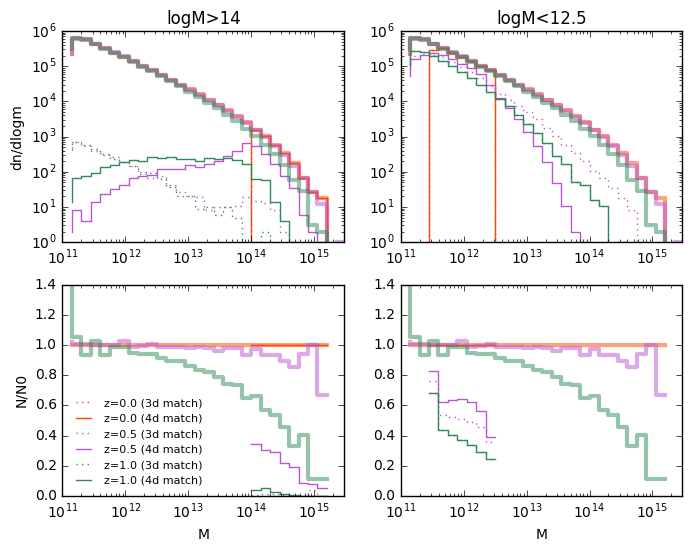

In [123]:
######### next try match ID #######
# idxcut14=where(Mvir0[idxcut]>10**14)[0]
# idxcut12=where(Mvir0[idxcut]<10**12.5)[0]

########## plot out the HMF for matched halos
hist_arr14z = [histogram(imvir[idxcut14], bins=ibins)[0] for imvir in 
            [Mvir0[idxcut], Mvir0b[idx_0b], Mvir0c[idx_0c]]]

hist_arr14zm = [histogram(imvir[idxcut14], bins=ibins)[0] for imvir in 
            [Mvir0[idxcut], Mvir0b[idx_m0b], Mvir0c[idx_m0c]]]

hist_arr12z = [histogram(imvir[idxcut12], bins=ibins)[0] for imvir in 
            [Mvir0[idxcut], Mvir0b[idx_0b], Mvir0c[idx_0c]]]

hist_arr12zm = [histogram(imvir[idxcut12], bins=ibins)[0] for imvir in 
            [Mvir0[idxcut], Mvir0b[idx_m0b], Mvir0c[idx_0c]]]


f, ((ax1,ax2),(ax3, ax4)) = subplots(2,2,figsize=(8,6))
for i in range(3):
    ## original HMF
    ax1.plot(ibins[1:], hist_arr[i], color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    ax3.plot(ibins[1:], hist_arr[i].astype(float)/hist_arr[0], 
             color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    
    ## 3d position matched HMF
    ax1.plot(ibins[1:], hist_arr14z[i],':',color=colors[i],
             label='z=%.1f (3d match)'%([0,0.5,1][i]),drawstyle='steps')
    ax3.plot(ibins[1:], hist_arr14z[i].astype(float)/hist_arr14z[0],':',
             color=colors[i],drawstyle='steps',
             label='z=%.1f (3d match)'%([0,0.5,1][i]))
    
    ## 4d pos+mass matched HMF
    ax1.plot(ibins[1:], hist_arr14zm[i],'-',color=colors[i],
            label='z=%.1f (4d match)'%([0,0.5,1][i]),drawstyle='steps')
    ax3.plot(ibins[1:], hist_arr14zm[i].astype(float)/hist_arr14zm[0],'-',color=colors[i],
            label='z=%.1f (4d match)'%([0,0.5,1][i]),drawstyle='steps')

    ########## M12
    ax2.plot(ibins[1:], hist_arr[i], color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    ax4.plot(ibins[1:], hist_arr[i].astype(float)/hist_arr[0], 
             color=colors[i], lw=3, alpha=0.5,drawstyle='steps')
    
    ## 3d position matched HMF
    ax2.plot(ibins2[1:], hist_arr12z[i],':',color=colors[i],
             label='Mnu=%.1f (3d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    ax4.plot(ibins2[1:], hist_arr12z[i].astype(float)/hist_arr12z[0],':',
             color=colors[i],drawstyle='steps',
             label='Mnu=%.1f (3d match)'%([0,0.1,0.6][i]))
    
    ## 4d pos+mass matched HMF
    ax2.plot(ibins2[1:], hist_arr12zm[i],'-',color=colors[i],
            label='Mnu=%.1f (4d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    ax4.plot(ibins2[1:], hist_arr12zm[i].astype(float)/hist_arr12zm[0],'-',color=colors[i],
            label='Mnu=%.1f (4d match)'%([0,0.1,0.6][i]),drawstyle='steps')
    
ax3.legend(fontsize=8, frameon=0,ncol=1,columnspacing=0.5,loc='lower left')
ax1.set_xlim(1e11, 3e15);ax2.set_xlim(1e11, 3e15)
ax3.set_xlim(1e11, 3e15);ax4.set_xlim(1e11, 3e15)
ax1.set_title('logM>14')
ax2.set_title('logM<12.5')
ax1.set_xscale('log');ax2.set_xscale('log')
ax3.set_xscale('log');ax4.set_xscale('log')
ax1.set_yscale('log');ax2.set_yscale('log')
ax3.set_xlabel('M');ax4.set_xlabel('M')
ax1.set_ylabel('dn/dlogm')
ax3.set_ylabel('N/N0')
show()

In [204]:
################## next plot Phm for matched halos ########
# PID0= load('cat/mnv_0.0_66_parents.npy').T[-1]
# PID1= load('cat/mnv_0.1_66_parents.npy').T[-1]
# PID6= load('cat/mnv_0.6_66_parents.npy').T[-1]

# ID0, Mvir0, Vmax0, Rvir0, Rs0, x0, y0, z0, Spin0, PID0 = load('cat/mnv_0.0_66_parents.npy')[PID0==-1].T
# ID1, Mvir1, Vmax1, Rvir1, Rs1, x1, y1, z1, Spin1, PID1 = load('cat/mnv_0.1_66_parents.npy')[PID1==-1].T
# ID6, Mvir6, Vmax6, Rvir6, Rs6, x6, y6, z6, Spin6, PID6 = load('cat/mnv_0.6_66_parents.npy')[PID6==-1].T

# Cvir0=Rvir0/Rs0
# Cvir6=Rvir6/Rs6
# Cvir1=Rvir1/Rs1

# idxcut=where(Mvir0>10**11.5)[0]
# idxcut14=where(Mvir0[idxcut]>10**14)[0]
# idxcut12=where(Mvir0[idxcut]<10**12.5)[0]

# dm06,idx_m06 = load('sep4D_idx_mnu0.0_mnu0.6.npy')
# dm01,idx_m01 = load('sep4D_idx_mnu0.0_mnu0.1.npy')

def Phm_matched_gen (mnu, N=66, Mcut=14.0, Mcutlo=12.5, Mmin=11.5, Nbin=Nbin, updateAB=0):
    ########### particles
    subsample_fn = 'snap/snapshot_mnv_%.1f/snapshot_%03d_idmod_101_0.hdf5'%(mnu,N)
    f=h5py.File(subsample_fn,'r')
    dataset = f[dataset_name]
    particle_pos = dataset['Position']/1e3
    gridP = gridding(particle_pos)
    k, Pmm = PS(gridP, gridP, dogrid=0) 
    
    ########### halos mnu=0
    ID, Mvir0, Vmax, Rvir, Rs, x, y, z, Spin, PID0 = load('cat/mnv_%.1f_%02d_parents.npy'%(0,N)).T
    idx = where((PID0==-1)&(log10(Mvir0)>Mmin))[0]
    ID, Mvir, Vmax, Rvir, Rs, x, y, z, Spin, PID = load('cat/mnv_%.1f_%02d_parents.npy'%(0,N))[idx,:].T
    Cvir=Rvir/Rs
    logM = log10(Mvir)
    
    ########## replace pos by massive model pos (matched halos)
    #halo_pos = array([x,y,z]).T
    if mnu==0.1:halo_pos = array([x1,y1,z1]).T[idx_m01]
    if mnu==0.6:halo_pos = array([x6,y6,z6]).T[idx_m06]
    if updateAB:
        if mnu==0.1:
            Cvir = Cvir1[idx_m01] 
            Spin = Spin1[idx_m01]
            Vmax = Vmax1[idx_m01]
        if mnu==0.6:
            Cvir = Cvir6[idx_m06] 
            Spin = Spin6[idx_m06]
            Vmax = Vmax6[idx_m06]

        
    k, Phm12 = PS(gridP, gridding(halo_pos[logM<Mcutlo]), dogrid=0)
    k, Phm14 = PS(gridP, gridding(halo_pos[logM>Mcut]), dogrid=0)
    
    ## shot noise
    Npart = len(particle_pos)
    Nmm = Lbox**3/Npart
    Nhm12 = Lbox**3/sqrt(Npart)/sqrt(sum(logM<Mcutlo))
    Nhm14 = Lbox**3/sqrt(Npart)/sqrt(sum(logM>Mcut))
    
    ####### for each AB property: 2 halo masses, hi/lo half-> 4 combinations
    
    logMbins0 = percentile(logM[(logM>Mmin) & (logM<Mcutlo)], linspace(0,100,101))
    logMbins1 = percentile(logM[(logM>Mcut) & (logM<15.5)], linspace(0,100,51))
    logMbins = unique(concatenate( [logMbins0, logMbins1]))
    
    out_AB_M12=zeros((3,2,Nbin))
    out_AB_M14=zeros((3,2,Nbin))
    Nhm_M12 = zeros((3,2))
    Nhm_M14 = zeros((3,2))
    
    i=0
    for ix in (Cvir, Vmax, Spin):
        print ['Cvir','Vmax', 'Spin'][i]
        ix_mark = zeros(logM.shape)
        for j in range(len(logMbins)-1): ####### put in mark for each mass bin
            iidx=where( (logM>logMbins[j]) & (logM<logMbins[j+1]))[0]
            ix_mark[iidx] = rankdata(ix[iidx])/len(iidx)
        k, iPhm14hi = PS(gridP, gridding(halo_pos[(logM>Mcut) & (ix_mark>0.5) ]), dogrid=0)
        k, iPhm14lo = PS(gridP, gridding(halo_pos[(logM>Mcut) & (ix_mark<0.5) ]), dogrid=0)
        k, iPhm12hi = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark>0.5)]), dogrid=0)
        k, iPhm12lo = PS(gridP, gridding(halo_pos[(logM<Mcutlo) & (ix_mark<0.5)]), dogrid=0)   
        out_AB_M12[i]=[iPhm12hi,iPhm12lo]
        out_AB_M14[i]=[iPhm14hi,iPhm14lo] 
        i+=1
    return k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], out_AB_M12, out_AB_M14

In [205]:
# for mnu in (0.1, 0.6):
#     out = Phm_matched_gen(mnu)
#     save('Phm/Pks_mnu%.1f_%i_matched.npy'%(mnu,66),out)
for mnu in (0.1, 0.6):
    out = Phm_matched_gen(mnu, updateAB=1)
    save('Phm/Pks_mnu%.1f_%i_matched_updatedAB.npy'%(mnu,66),out)

Cvir
Vmax
Spin
Cvir
Vmax
Spin


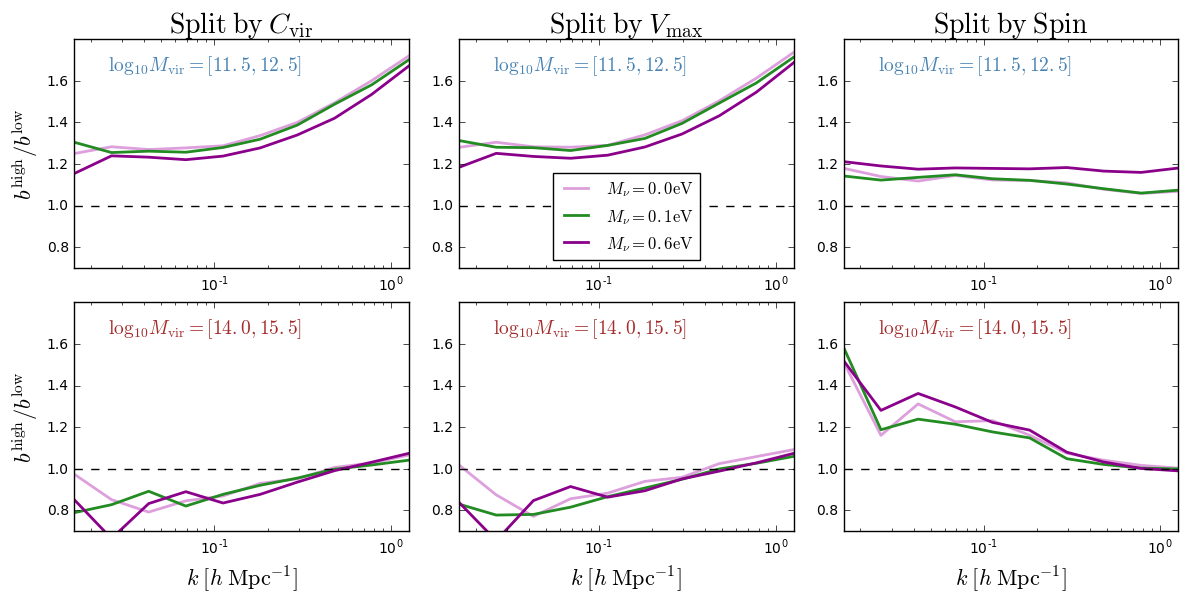

In [201]:
f, [axes, axes2] = subplots(2,3, figsize=(12,6))
for j in range(3): ## cvir, vmax, spin counter(1,):#(1,):#
    jlabel=[r'${\rm Split\; by\;} C_{\rm vir}$', 
            r'${\rm Split\; by\;} V_{\rm max}$', 
            r'${\rm Split\; by\; Spin}$'][j]
    for nmnu in range(3): ## neutrino mass counter
        mnu=[0,0.1, 0.6][nmnu]
        k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], AB_M12, AB_M14 = load('Phm/Pks_mnu%.1f_66.npy'%(mnu))
        ilabel = r'$M_\nu= %.1f {\rm eV}$'%(mnu)
        axes[j].plot(k, AB_M12[j,0]/AB_M12[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
        axes2[j].plot(k, AB_M14[j,0]/AB_M14[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
    axes[j].set_title(jlabel, fontsize=20)
    axes[j].set_xscale('log'); axes2[j].set_xscale('log')
    axes[j].set_xlim(k[0],k[-1]);axes2[j].set_xlim(k[0],k[-1])
    axes[j].set_ylim(0.7, 1.8);axes2[j].set_ylim(0.7, 1.8)
    axes[j].text(0.025, 1.65, r'$\log_{10}M_{\rm vir}=[11.5, 12.5]$', fontsize=14, color='steelblue')
    axes2[j].text(0.025, 1.65, r'$\log_{10}M_{\rm vir}=[14.0, 15.5]$', fontsize=14, color='brown')

    axes[j].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[j].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[j].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=16)
axes[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes2[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes[1].legend(loc='lower center', frameon=1, fontsize=12, columnspacing=0.5)
    
subplots_adjust(left=0.06, bottom=0.1, right=0.98, top=0.92, wspace=0.15, hspace=0.15)
#savefig('plots/assemblybias_z0.pdf');close()

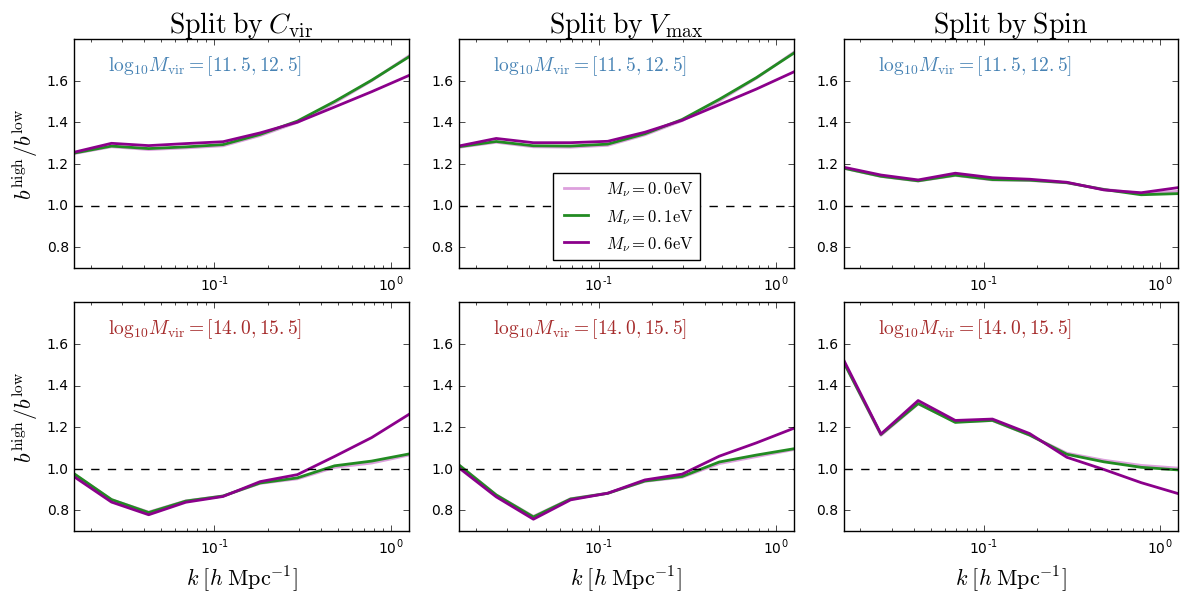

In [199]:
########### matched halos
f, [axes, axes2] = subplots(2,3, figsize=(12,6))
for j in range(3): ## cvir, vmax, spin counter(1,):#(1,):#
    jlabel=[r'${\rm Split\; by\;} C_{\rm vir}$', 
            r'${\rm Split\; by\;} V_{\rm max}$', 
            r'${\rm Split\; by\; Spin}$'][j]
    for nmnu in range(3): ## neutrino mass counter
        mnu=[0,0.1, 0.6][nmnu]
        k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], AB_M12, AB_M14 = load('Phm/Pks_mnu%.1f_66_matched.npy'%(mnu))
        ilabel = r'$M_\nu= %.1f {\rm eV}$'%(mnu)
        axes[j].plot(k, AB_M12[j,0]/AB_M12[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
        axes2[j].plot(k, AB_M14[j,0]/AB_M14[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
    axes[j].set_title(jlabel, fontsize=20)
    axes[j].set_xscale('log'); axes2[j].set_xscale('log')
    axes[j].set_xlim(k[0],k[-1]);axes2[j].set_xlim(k[0],k[-1])
    axes[j].set_ylim(0.7, 1.8);axes2[j].set_ylim(0.7, 1.8)
    axes[j].text(0.025, 1.65, r'$\log_{10}M_{\rm vir}=[11.5, 12.5]$', fontsize=14, color='steelblue')
    axes2[j].text(0.025, 1.65, r'$\log_{10}M_{\rm vir}=[14.0, 15.5]$', fontsize=14, color='brown')

    axes[j].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[j].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[j].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=16)
axes[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes2[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes[1].legend(loc='lower center', frameon=1, fontsize=12, columnspacing=0.5)#, title=jlabel)
    
subplots_adjust(left=0.06, bottom=0.1, right=0.98, top=0.92, wspace=0.15, hspace=0.15)
#savefig('plots/assemblybias_z0_matched.pdf');close()

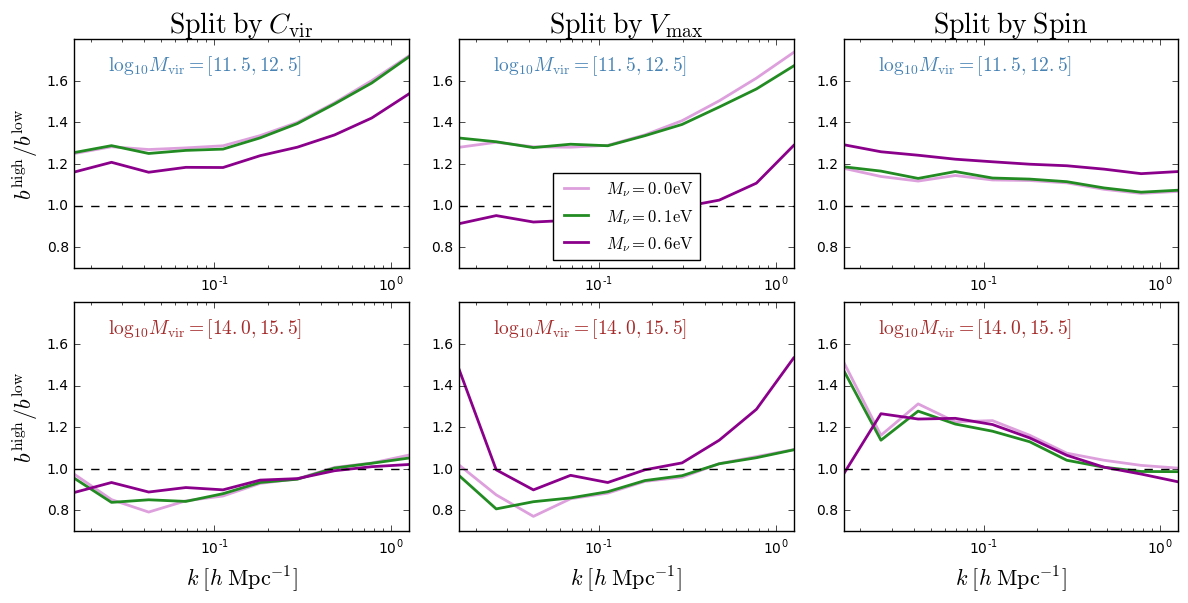

In [208]:
############# matched halos, with updated AB properties

f, [axes, axes2] = subplots(2,3, figsize=(12,6))
for j in range(3): ## cvir, vmax, spin counter(1,):#(1,):#
    jlabel=[r'${\rm Split\; by\;} C_{\rm vir}$', 
            r'${\rm Split\; by\;} V_{\rm max}$', 
            r'${\rm Split\; by\; Spin}$'][j]
    for nmnu in range(3): ## neutrino mass counter
        mnu=[0,0.1, 0.6][nmnu]
        k, [Pmm, Nmm], [Phm12, Nhm12], [Phm14, Nhm14], AB_M12, AB_M14 = load('Phm/Pks_mnu%.1f_66_matched_updatedAB.npy'%(mnu))
        ilabel = r'$M_\nu= %.1f {\rm eV}$'%(mnu)
        axes[j].plot(k, AB_M12[j,0]/AB_M12[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
        axes2[j].plot(k, AB_M14[j,0]/AB_M14[j,1], color=colors[nmnu+5], lw=2, label=ilabel)
    axes[j].set_title(jlabel, fontsize=20)
    axes[j].set_xscale('log'); axes2[j].set_xscale('log')
    axes[j].set_xlim(k[0],k[-1]);axes2[j].set_xlim(k[0],k[-1])
    axes[j].set_ylim(0.7, 1.8);axes2[j].set_ylim(0.7, 1.8)
    axes[j].text(0.025, 1.65, r'$\log_{10}M_{\rm vir}=[11.5, 12.5]$', fontsize=14, color='steelblue')
    axes2[j].text(0.025, 1.65, r'$\log_{10}M_{\rm vir}=[14.0, 15.5]$', fontsize=14, color='brown')

    axes[j].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[j].plot([k[0], k[-1]], ones(2),'k--',lw=1)
    axes2[j].set_xlabel(r'$k\; [h \;{\rm Mpc}^{-1}]$', fontsize=16)
axes[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes2[0].set_ylabel(r'$b^{\rm high}/b^{\rm low}$', fontsize=16)
axes[1].legend(loc='lower center', frameon=1, fontsize=12, columnspacing=0.5)#, title=jlabel)
    
subplots_adjust(left=0.06, bottom=0.1, right=0.98, top=0.92, wspace=0.15, hspace=0.15)
#savefig('plots/assemblybias_z0_matched_updatedAB.pdf');close()

In [ ]:
########### check what changed in Cvir, Vmax, Spin for 1-on-1 matched halos
